In [222]:
import pandas as pd
import numpy as np
from scipy.special import softmax
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import cv2

import os
import re

import keras
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertModel

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from transformers import AutoTokenizer, TFDistilBertModel, TFAutoModel, Trainer, TrainingArguments,TFAutoModelForSequenceClassification



In [174]:
df = pd.read_csv('MELD.Raw/train_sent_emo.csv',encoding='utf-8')
df['Utterance'] = df.Utterance.str.replace('',"'")

emotions = ['negative', 'neutral', 'positive']

In [463]:
optimizer = 'adam'
loss = 'categorical_crossentropy'
batch_size = 64
metrics = ['accuracy',
        #    keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
         #   keras.metrics.AUC(num_thresholds=200,curve="ROC",summation_method="interpolation",name='auc',dtype=None,thresholds=None, multi_label=True,num_labels=3,label_weights=None,from_logits=False),
        #    keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
        #    keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
           ]




early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  
    patience=8,          
    verbose=4,           
    restore_best_weights=True)

In [176]:
min_size = df.Sentiment.value_counts().min()

dataframes = []

for emotion in df.Sentiment.unique():
    dataframes.append(df[df.Sentiment == emotion].sample(min_size, ignore_index=True))

df = pd.concat(dataframes, ignore_index=True)           
df = df.sample(frac=0.3, ignore_index=True)
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1007,"Well then, what is it?!",Ross,surprise,negative,101,1,6,23,"00:05:59,150","00:06:00,525"
1,9200,"Look, I just saw my best friends brains smeare...",Student,sadness,negative,920,0,3,7,"00:16:48,215","00:16:56,472"
2,5354,"Eh, I mean, I mena she's not unattractive but ...",Ross,surprise,positive,539,3,9,12,"00:01:16,326","00:01:23,499"
3,2375,"Oh, you really want to talk about getting peop...",Monica,anger,negative,234,11,7,9,"00:11:55,673","00:11:59,759"
4,454,"Joe, your dad's in love big time. And the wors...",Mr. Tribbiani,neutral,neutral,41,13,1,13,"00:05:50,433","00:05:58,648"
...,...,...,...,...,...,...,...,...,...,...,...
2096,1240,"Monica, you don't even have a bed, you sleep i...",Rachel,anger,negative,126,7,4,19,"00:01:15,784","00:01:19,661"
2097,8152,"I'm sorry, do I know you?",Joey,neutral,neutral,820,1,7,19,"00:00:08,842","00:00:11,260"
2098,5273,I'm sorry.,Ross,sadness,negative,531,6,6,4,"00:20:25,974","00:20:28,184"
2099,5220,Ohh! You made up!,Phoebe,surprise,positive,527,2,5,24,"0:08:06,528","0:08:09,007"


In [217]:
face_model = tf.keras.applications.VGG16(input_shape=(48,48,3),
                                        include_top=False,
                                        weights="imagenet") #include_top=True for predictions, False for embeddings

In [40]:
# from keras_vggface.vggface import VGGFace

# # VGGFace model
# face_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')


In [178]:
import sys

def find_largest_global():
    largest_var_name = None
    largest_size = 0

    for var_name, var_value in globals().items():
        # Skip built-in modules and functions
        if not var_name.startswith('__') and not callable(var_value):
            size = sys.getsizeof(var_value)
            if size > largest_size:
                largest_size = size
                largest_var_name = var_name

    return largest_var_name, largest_size

The following produces detector embeddings without the use of a NN model.

In [179]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/train_splits/'
one_face_videos = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = single_video_embeddings
        else:
            one_face_videos[file_name] = 'too many faces' 



In [180]:
df['many_faces'] = one_face_videos.values()
df['wrong_shape'] = [np.array(value).shape for value in one_face_videos.values() if value != None]

df = df[(df.many_faces != 'too many faces') & (df.wrong_shape == (1,48,48,3))]



In [181]:
split_size = int(len(df) * 0.8)


In [182]:
def preprocess(text):
    t = text.lower()
    t = re.sub('\d+',r'',t)
    t = re.sub(r'\W+',r' ',t)
    return t

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])
                .strip() for txt in df['Utterance']]

C:\Users\gsevr\AppData\Local\Temp\ipykernel_86944\2616501896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])


In [183]:
ohe = OneHotEncoder(categories=[['negative', 'neutral', 'positive']])
labels = ohe.fit_transform(df.Sentiment.to_numpy().reshape(-1,1)).toarray()
labels_train = labels[:split_size]
labels_val = labels[split_size:]

In [184]:
df_train = df.iloc[:split_size]
df_val = df.iloc[split_size:]

The following uses detector embeddings to fine tune the VGG16 model

In [477]:
#this includes transfer learning for vgg16 and makes predictions based on that.
from tensorflow.keras.layers import BatchNormalization, Activation

for layer in face_model.layers[:-4]:
    layer.trainable=False

# for layer in face_model.layers[-4:]:
#     layer.trainable = True

base = face_model.output

vid_pred_model = Sequential()
vid_pred_model.add(face_model)
# vid_pred_model.add(Dropout(0.2))
vid_pred_model.add(Flatten())
# vid_pred_model.add(BatchNormalization())
vid_pred_model.add(Dense(32, activation='relu'))
# vid_pred_model.add(BatchNormalization())
# vid_pred_model.add(Dropout(0.2))
# vid_pred_model.add(Dense(64,kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2()))
# vid_pred_model.add(BatchNormalization())
# vid_pred_model.add(Activation('relu'))
# vid_pred_model.add(Dropout(0.5))
vid_pred_model.add(Dense(16,activation='relu'))
# vid_pred_model.add(BatchNormalization())
vid_pred_model.add(Dense(3,activation='softmax'))

vid_pred_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



In [196]:
vid_train_data = []
for video in [value for value in one_face_videos.values() if value != None and np.array(value).shape == (1,48,48,3)]:
    video = tf.reduce_mean(video,axis=0)
    vid_train_data.append(video)

vid_train = np.array(vid_train_data)[:split_size]
vid_val = np.array(vid_train_data)[split_size:]

In [478]:
history_vid_pred = vid_pred_model.fit(vid_train,labels_train,epochs=5, validation_data=(vid_val,labels_val), batch_size=32)

Epoch 1/5
47/47 [==============================] - 85s 2s/step - loss: 2.9937 - accuracy: 0.3286 - val_loss: 1.0939 - val_accuracy: 0.3649
Epoch 2/5
47/47 [==============================] - 86s 2s/step - loss: 1.0838 - accuracy: 0.3847 - val_loss: 1.1190 - val_accuracy: 0.3486
Epoch 3/5
47/47 [==============================] - 89s 2s/step - loss: 1.0488 - accuracy: 0.4172 - val_loss: 1.1844 - val_accuracy: 0.3189
Epoch 4/5
47/47 [==============================] - 88s 2s/step - loss: 1.0046 - accuracy: 0.4861 - val_loss: 1.1769 - val_accuracy: 0.3378
Epoch 5/5
47/47 [==============================] - 87s 2s/step - loss: 0.9854 - accuracy: 0.4733 - val_loss: 1.2747 - val_accuracy: 0.3297


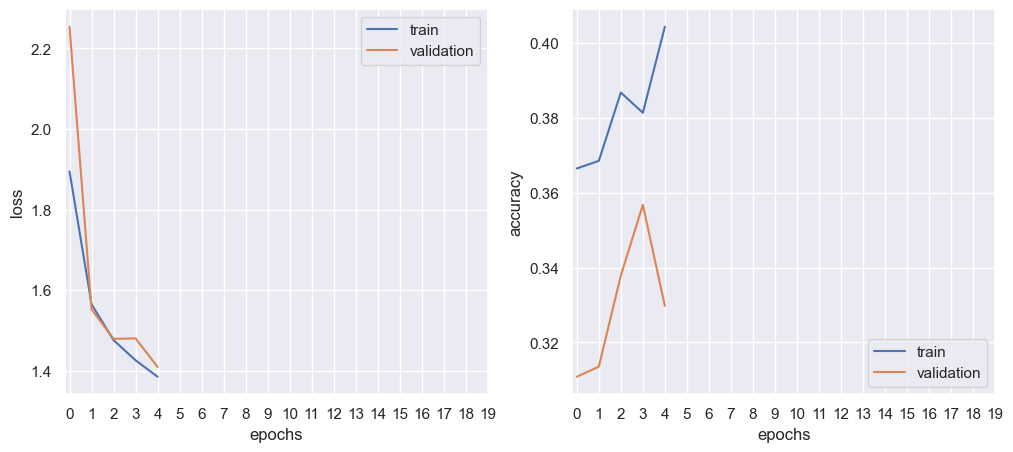

In [267]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vid_pred.history['loss'])
plt.plot(history_vid_pred.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_vid_pred.history['accuracy'])
plt.plot(history_vid_pred.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()

In [551]:
# video predictions

video_predictions = vid_pred_model.predict(vid_val)
video_predictions


12/12 [==============================] - 6s 459ms/step


array([[0.4736205 , 0.46018827, 0.06619122],
       [0.30109668, 0.3366575 , 0.36224583],
       [0.49685273, 0.44149944, 0.06164784],
       ...,
       [0.55075896, 0.38386145, 0.06537963],
       [0.32321241, 0.37204546, 0.30474213],
       [0.6775986 , 0.31751305, 0.00488839]], dtype=float32)

In [301]:
# this is designed to extract the embeddings from the fine tuned model

video_embedding_layers = [layer for layer in vid_pred_model.layers[:-3]]

video_embedding_model_input = vid_pred_model.input
video_embedding_model_output = video_embedding_layers[-1].output
video_embedding_model = Model(video_embedding_model_input, video_embedding_model_output)

video_embedding_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [303]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/train_splits/'
video_embeddings = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = single_video_embeddings
        else:
            video_embeddings[file_name] = 'too many faces' 



In [150]:
from transformers import RobertaConfig
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
# model_name = 'bhadresh-savani/distilbert-base-uncased-emotion'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = RobertaConfig.from_pretrained(model_name, output_hidden_states=True)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, config=config)



All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [151]:
train_encodings = tokenizer([text for text in df_train.Utterance.values], return_tensors='tf', padding=True, truncation=True)
val_encodings = tokenizer([text for text in df_val.Utterance.values], return_tensors='tf', padding=True, truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [152]:
train_preds = model(**train_encodings)
val_preds = model(**val_encodings)

In [171]:
text_preds = softmax(val_preds[0],axis=1)

p = [emotions[i] for i in np.argmax(text_preds,axis=1)]

In [172]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(df_val.Sentiment.values, p)

accuracy_score(df_val.Sentiment.values, p)

0.5890736342042755

In [348]:
# THIS GETS EMBEDDINGS FROM DF

df_encodings = tokenizer([text for text in df.Utterance.values], return_tensors='tf', padding=True, truncation=True)
df_preds = model(**df_encodings)
df_text_preds = softmax(df_preds[0],axis=1)
text_embeddings = df_preds[1]
text_embeddings



(<tf.Tensor: shape=(1849, 92, 768), dtype=float32, numpy=
 array([[[ 0.13776219, -0.07992195, -0.00446574, ..., -0.04688763,
           0.05868359,  0.04299733],
         [ 0.00208429,  0.19561026,  0.5559369 , ..., -0.22188988,
          -0.12185022,  0.4277802 ],
         [ 0.22600627, -0.11109281,  0.28835094, ...,  0.12026571,
          -0.6157516 ,  0.07366955],
         ...,
         [-0.50868213,  0.506925  ,  0.00080039, ..., -0.39926678,
           0.31462133, -0.36372456],
         [-0.50868213,  0.506925  ,  0.00080039, ..., -0.39926678,
           0.31462133, -0.36372456],
         [-0.50868213,  0.506925  ,  0.00080039, ..., -0.39926678,
           0.31462133, -0.36372456]],
 
        [[ 0.13776219, -0.07992195, -0.00446574, ..., -0.04688763,
           0.05868359,  0.04299733],
         [-0.252655  , -0.6494838 , -0.13728143, ...,  0.6006166 ,
          -0.26620454,  0.29402825],
         [ 0.39599666,  0.07245521, -0.03001726, ..., -0.58689195,
          -0.30259293,  0.

In [459]:
text_embeddings_fn = np.mean(text_embeddings[12],axis=1)
video_embeddings_array = np.array([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])
video_embeddings_array_fn = tf.reduce_mean(video_embeddings_array, axis=4).reshape(len(video_embeddings_array),-1)

con_ten = np.concatenate([text_embeddings_fn, video_embeddings_array_fn],axis=1)


In [460]:
fusion_data = np.squeeze(np.array([con_ten],dtype=np.float16))
fusion_train = fusion_data[:split_size]
fusion_val = fusion_data[split_size:]

In [464]:
# Model for early fusion

fusion_model = Sequential()

fusion_model.add(Dense(256, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(128, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(64, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(len(emotions), activation='softmax'))

fusion_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

fusion_model_history = fusion_model.fit(fusion_train,labels_train,epochs=20, validation_data=(fusion_val,labels_val), batch_size=batch_size, callbacks=[early_stopping_callback])

Epoch 1/20
24/24 [==============================] - 6s 232ms/step - loss: 4.4323 - accuracy: 0.3550 - val_loss: 1.3423 - val_accuracy: 0.4811
Epoch 2/20
24/24 [==============================] - 5s 225ms/step - loss: 1.4012 - accuracy: 0.4699 - val_loss: 2.3354 - val_accuracy: 0.4595
Epoch 3/20
24/24 [==============================] - 5s 212ms/step - loss: 1.5025 - accuracy: 0.4970 - val_loss: 0.9696 - val_accuracy: 0.5865
Epoch 4/20
24/24 [==============================] - 5s 221ms/step - loss: 0.9105 - accuracy: 0.6220 - val_loss: 0.9684 - val_accuracy: 0.5811
Epoch 5/20
24/24 [==============================] - 5s 221ms/step - loss: 0.9601 - accuracy: 0.5970 - val_loss: 1.2464 - val_accuracy: 0.4649
Epoch 6/20
24/24 [==============================] - 5s 221ms/step - loss: 0.8572 - accuracy: 0.6200 - val_loss: 1.1432 - val_accuracy: 0.5189
Epoch 7/20
24/24 [==============================] - 5s 216ms/step - loss: 0.8867 - accuracy: 0.6254 - val_loss: 1.0537 - val_accuracy: 0.5622
Epoch 

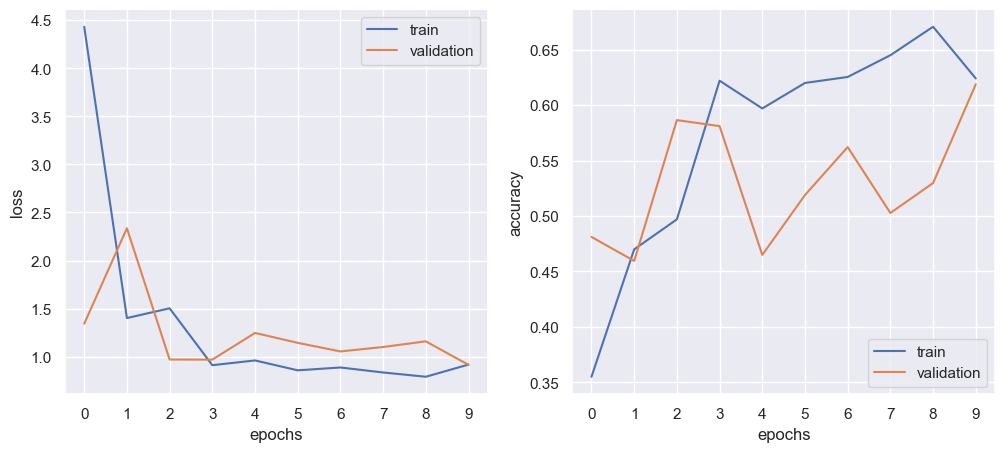

In [474]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fusion_model_history.history['loss'][:10])
plt.plot(fusion_model_history.history['val_loss'][:10])
plt.xticks([i for i in range(0,10)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(fusion_model_history.history['accuracy'][:10])
plt.plot(fusion_model_history.history['val_accuracy'][:10])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,10)])

plt.show()

In [432]:
# Late fusion

def final_preds(text_model_predictions, visual_model_predictions):
    final_predictions = []
    emotions = ['negative', 'neutral', 'positive']

    for text_pred, vis_pred in zip(text_model_predictions, visual_model_predictions):
        text_max = np.argmax(text_pred)
        vis_max = np.argmax(vis_pred)

        # Equal predictions
        if text_max == vis_max:
            final_prediction = emotions[text_max]
            print('Equal predictions')

        # Different predictions, lean towards higher confidence
        else:
            final_prediction_value = np.maximum(a := np.round(text_pred[text_max], 8), 
                                                b := np.round(vis_pred[vis_max], 8))

            try:
                print(f'Text: {a}, Visual: {b}')
                final_prediction = emotions[np.where(np.round(text_pred, 8) == final_prediction_value)[0][0]]
                print('Text wins')
            except IndexError:
                final_prediction = emotions[np.where(np.round(vis_pred, 8) == final_prediction_value)[0][0]]
                print('Visual wins')

        final_predictions.append(final_prediction)

    return final_predictions


In [433]:
late_fusion_predictions = final_preds(text_preds, video_predictions)

#TODO Confusion matrix

Text: 0.0015555999707430601, Visual: 0.4011552929878235
Visual wins
Equal predictions
Text: 0.000996679998934269, Visual: 0.3939070701599121
Visual wins
Equal predictions
Text: 0.005667190067470074, Visual: 0.44198477268218994
Visual wins
Equal predictions
Text: 0.001304580015130341, Visual: 0.4400853216648102
Visual wins
Equal predictions
Text: 0.0012113399570807815, Visual: 0.3981953263282776
Visual wins
Equal predictions
Equal predictions
Equal predictions
Text: 0.0013185599818825722, Visual: 0.3614575266838074
Visual wins
Equal predictions
Text: 0.0007091800216585398, Visual: 0.6195797324180603
Visual wins
Text: 0.0064466302283108234, Visual: 0.4297981262207031
Visual wins
Text: 0.0008238499867729843, Visual: 0.465117484331131
Visual wins
Equal predictions
Text: 0.01123129017651081, Visual: 0.4356868863105774
Visual wins
Text: 0.0015169200487434864, Visual: 0.5293266773223877
Visual wins
Text: 0.0008621899760328233, Visual: 0.3970896899700165
Visual wins
Equal predictions
Equal pre

In [434]:

accuracy_score(df_val.Sentiment.values, late_fusion_predictions)

0.32972972972972975

In [435]:
confusion_matrix(df_val.Sentiment.values, late_fusion_predictions)

array([[59, 43, 29],
       [59, 33, 32],
       [58, 27, 30]], dtype=int64)

In [532]:
tved_df = pd.read_csv('TVED Dataset.csv')
tved_df

,utterance,sentiment,emotion,check,By,prepro
0,"01. ""Feeling down today, everything seems a bi...",negative,Sadness,True,A,feeling down today everything seems a bit grey
1,"02. ""Just can't shake off this feeling of heav...",negative,Sadness,True,A,just cant shake off this feeling of heaviness
2,"03. ""It's like a weight in my chest that won't...",negative,Sadness,True,A,its like a weight in my chest that wont go away
3,"04. ""Trying to find some light in this darknes...",negative,Sadness,True,A,trying to find some light in this darkness bu...
4,"05. ""Feeling a bit lost and not sure how to li...",negative,Sadness,True,I,feeling a bit lost and not sure how to lift m...
...,...,...,...,...,...,...
65,"06. ""Terrified about what might happen, need t...",negative,Fear,True,M,terrified about what might happen need to sta...
66,"07. ""Fearing the worst, trying to keep a brave...",negative,Fear,True,M,fearing the worst trying to keep a brave face
67,"08. ""Feeling a knot in my stomach, scared to m...",negative,Fear,True,E,feeling a knot in my stomach scared to move f...
68,"09. ""That was really frightening, still shaking.""",negative,Fear,True,E,that was really frightening still shaking


In [533]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'Emotions dataset/Good/'
one_face_videos = {}

for idx, row in tved_df.iterrows():
    file_name = str(row['emotion']) + ' ' + row['utterance'][:2] + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = single_video_embeddings
        else:
            one_face_videos[file_name] = 'too many faces' 



In [534]:
tved_df['many_faces'] = one_face_videos.values()
tved_df['wrong_shape'] = [np.array(value).shape for value in one_face_videos.values() if value != None]

tved_df = tved_df[(tved_df.many_faces != 'too many faces') & (tved_df.wrong_shape == (1,48,48,3))]



In [545]:
tved_labels = ohe.fit_transform(tved_df.sentiment.to_numpy().reshape(-1,1)).toarray()


In [536]:
tved_vid_train_data = []
for video in [value for value in one_face_videos.values() if value != None and np.array(value).shape == (1,48,48,3)]:
    video = tf.reduce_mean(video,axis=0)
    tved_vid_train_data.append(video)

In [541]:
tved_vid_preds = vid_pred_model.predict(np.array(tved_vid_train_data))

3/3 [==============================] - 1s 303ms/step


In [550]:
p = np.argmax(tved_vid_preds,axis=1)

In [553]:
accuracy_score(np.argmax(tved_labels,axis=1),p)

0.38571428571428573

In [563]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'Emotions dataset/Good/'
video_embeddings = {}

for idx, row in tved_df.iterrows():
    file_name = str(row['emotion']) + ' ' + row['utterance'][:2] + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = single_video_embeddings
        else:
            video_embeddings[file_name] = 'too many faces' 



In [566]:
tved_encodings = tokenizer([text for text in tved_df.utterance.values], return_tensors='tf', padding=True, truncation=True)
tved_text_preds = model(**tved_encodings)
tved_text_preds = softmax(tved_text_preds[0],axis=1)
p = [emotions[i] for i in np.argmax(tved_text_preds,axis=1)]
accuracy_score(tved_df.sentiment.values, p)



0.8

In [567]:
tved_df_encodings = tokenizer([text for text in tved_df.utterance.values], return_tensors='tf', padding=True, truncation=True)
tved_df_preds = model(**tved_df_encodings)
tved_text_embeddings = tved_df_preds[1]
tved_text_embeddings

(<tf.Tensor: shape=(70, 20, 768), dtype=float32, numpy=
 array([[[ 1.37762189e-01, -7.99219534e-02, -4.46573924e-03, ...,
          -4.68876287e-02,  5.86835891e-02,  4.29973304e-02],
         [ 3.79110724e-02, -1.30037308e-01,  1.10452600e-01, ...,
          -3.41087878e-01, -5.84595084e-01,  1.10485815e-01],
         [ 2.92314142e-01, -5.71601987e-02,  3.89317982e-02, ...,
          -8.50661874e-01, -1.95080251e-01,  4.08580422e-01],
         ...,
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01],
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01],
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01]],
 
        [[ 1.37762189e-01, -7.99219534e-02, -4.46573924e-03, ...,
          -4.68876287e-02,  5.86835891e-02,  4.29973304e-02],
         [-1.05869010e-01, -6.3

In [569]:
tved_text_embeddings_fn = np.mean(tved_text_embeddings[12],axis=1)
tved_video_embeddings_array = np.array([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])
tved_video_embeddings_array_fn = tf.reduce_mean(tved_video_embeddings_array, axis=4).reshape(len(tved_video_embeddings_array),-1)

tved_con_ten = np.concatenate([tved_text_embeddings_fn, tved_video_embeddings_array_fn],axis=1)


In [580]:
tved_fusion_data = np.squeeze(np.array([tved_con_ten],dtype=np.float16))


In [581]:
tved_fusion_preds = fusion_model.predict(tved_fusion_data)


3/3 [==============================] - 0s 28ms/step


In [582]:
q = np.argmax(tved_fusion_preds,axis=1)

In [583]:
accuracy_score(np.argmax(tved_labels,axis=1), q)


0.8142857142857143

In [584]:
tved_late_fusion_predictions = final_preds(tved_text_preds, tved_vid_preds)


Equal predictions
Equal predictions
Equal predictions
Text: 0.6255610585212708, Visual: 0.5873778462409973
Text wins
Equal predictions
Text: 0.45937448740005493, Visual: 0.5020958185195923
Visual wins
Equal predictions
Equal predictions
Equal predictions
Equal predictions
Text: 0.654090166091919, Visual: 0.5691002607345581
Text wins
Equal predictions
Text: 0.7181044220924377, Visual: 0.5836889147758484
Text wins
Text: 0.700660228729248, Visual: 0.6006942987442017
Text wins
Text: 0.4042772352695465, Visual: 0.5082132816314697
Visual wins
Text: 0.43857648968696594, Visual: 0.49121183156967163
Visual wins
Text: 0.45509618520736694, Visual: 0.4826807975769043
Visual wins
Text: 0.9605651497840881, Visual: 0.5317131876945496
Text wins
Text: 0.737758219242096, Visual: 0.5600553154945374
Text wins
Text: 0.973134458065033, Visual: 0.4496672749519348
Text wins
Text: 0.4978858530521393, Visual: 0.5846297144889832
Visual wins
Text: 0.5822760462760925, Visual: 0.5985816121101379
Visual wins
Text: 0

In [586]:
accuracy_score(tved_df.sentiment.values, tved_late_fusion_predictions)

0.7571428571428571